In [1]:
import numpy as np
from scipy.io import loadmat
import sys
import scipy.stats as stats
from scipy.stats import norm
from tqdm import tqdm
import copy

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch

In [2]:
import matplotlib.pyplot as plt
import scipy
import swyft
#import lightning as L 
import pytorch_lightning as pl
import seaborn as sns
pi = np.pi
sqrt = np.sqrt


sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# No Summarizer

In [3]:
def cal_cls_mc_pl(lmax,c,d):
    cl_mc = np.zeros(lmax+1)
    a_mc_sig = np.zeros(lmax+1)
    for l in range(lmax+1):
        cl_mc[l] = d*(l**c) 
        a_mc_sig[l] = np.sqrt(cl_mc[l] / 2.0)    # calculate sigma of real (and imaginary) parts of Plms 
    return cl_mc, a_mc_sig

def find_lm(l,m,Lmax): # function to find appropriate index in plm array corresponding to a particular lm pair
    lvec, mvec = [], []
    for mm in range(Lmax+1):
        lvec += range(mm, Lmax+1)
        mvec += [mm]*(Lmax+1-mm)
    lvec = np.hstack((np.flipud(lvec[1+Lmax:]), lvec))
    mvec = np.hstack((-np.flipud(mvec[1+Lmax:]), mvec))
    q = (Lmax+1)**2
    lms=(np.array(lvec.tolist()+mvec.tolist())).reshape(2,q)
    # search for desired l,m in the list we have made
    for ii in range((Lmax+1)**2):
        if l==lms[0][ii] and m==lms[1][ii]:
            return ii

def getlm(l_max):
    lvec, mvec = [], []
    for mm in range(l_max+1):
        lvec += range(mm, l_max+1)
        mvec += [mm]*(l_max+1-mm)
    lvec = np.hstack((np.flipud(lvec[1+l_max:]), lvec))
    mvec = np.hstack((-np.flipud(mvec[1+l_max:]), mvec))
    q = (l_max+1)**2
    return (np.array(lvec.tolist()+mvec.tolist())).reshape(2,q)


def complex_getlm(l_max):
    ''' Creates a list of l and m in the order they appear in a a_lm array.
    Replacement of hp.Alm.getlm, that includes -m'''

    lvec, mvec = [], []
    for mm in range(l_max+1):
        lvec += range(mm, l_max+1)
        mvec += [mm]*(l_max+1-mm)
    lvec = np.hstack((np.flipud(lvec[1+l_max:]), lvec))
    mvec = np.hstack((-np.flipud(mvec[1+l_max:]), mvec))
    q = (l_max+1)**2
    return (np.array(lvec.tolist()+mvec.tolist())).reshape(2,q)

def subFisher(fisher, lmax_sub):

    #get the sub fisher matrix for an lmax = lmax_sub
    """
    ---parameters---
    fisher: sph fisher matrix from PyStoch
    lmax_sub:  l_max value of the new fisher matrix

    Example: subFisher(fisher,3)
    """

    N = len(fisher)
    l_max = int(np.sqrt(N)-1)
    if lmax_sub>l_max:
        sub_fisher = fisher
        print ('appended the original fisher')
    else:
        lvec, mvec = complex_getlm(l_max)
        ind = lvec<=lmax_sub
        sub_fisher = fisher[ind].T[ind].T
    return sub_fisher

def subDirtymap(dirtymap, lmax_sub):
    
    #get the sub dirty map for an lmax = lmax_sub
    """
    ---parameters---
    dirtymap: sph dirty map from PyStoch
    lmax_sub: l_max value of the new dirty map

    Example: subDirtymap(dirtymap,3)
    """

    x = dirtymap.reshape(dirtymap.size, 1)
    N = len(x)
    l_max = int(np.sqrt(N)-1)
    if lmax_sub>l_max:
        sub_x = x
        print('appended the original dirty map')
    else:
        lvec, mvec = complex_getlm(l_max)
        ind = lvec<=lmax_sub
        y = x[ind]
        sub_x = y[:,0]
    return sub_x

def cal_Xl_model_from_Al_model(lmax, cl_mc, subfisher):
    lvec, mvec = complex_getlm(lmax)
    Xl = np.zeros(lmax+1)
    Al = cl_mc
    for l in range(lmax+1):  
        for m in range(-l, l+1):    
            for ll in range(lmax+1):          
                for mm in range(-ll, ll+1):
                    lm = find_lm(l,m,lmax)
                    llmm = find_lm(ll,mm,lmax)
                    Xl[l] += Al[ll] * np.absolute(subfisher[lm, llmm])**2 # Erik proved that this is a 1-1 map
        Xl[l] = (1 / (2 * l + 1)) * Xl[l]
    return Xl[1:]

def cal_xlm_model(lmax,a_mc_sig,Cl_mc,subfisher):
    plm_model = np.zeros((Lmax+1)**2).astype(complex)
    flag = True
    while flag == True:
        for l in range(Lmax+1):
            for m in range(l+1):
                if l == 0:
                    a = norm.rvs(size=1,loc=0,scale=np.sqrt(2)*a_mc_sig[l]) 
                    b = 0
                elif m == 0:
                    a = norm.rvs(size=1,loc=0,scale=np.sqrt(2)*a_mc_sig[l])         # draw random real part of plm
                    b = 0
                else:
                    a = norm.rvs(size=1,loc=0,scale=a_mc_sig[l])         # draw random real part of plm
                    b = norm.rvs(size=1,loc=0,scale=a_mc_sig[l])         # do the same thing independently for the imaginary part
                idx = find_lm(l,m,Lmax)
                plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
                idx2 = find_lm(l,-m,Lmax)
                sign = ((-1)**m)                                         # follow requirement that P_{l,-m} = (-1)^m * P_{l,m}
                plm_model[idx2] = complex(sign*a,sign*(-b))
        flag = False
    X_m = np.matmul(subfisher , plm_model)
    return X_m, plm_model

def cal_Xl_model_from_xlm_model(lmax,X_m, subfisher): #calculate model Cls in the dirty map space
    ells = np.arange(lmax+1)
    lvec, mvec = complex_getlm(lmax)
    sig_X_lm = subfisher #gamma_fisher
    n_ells = np.real(np.array([sum(np.diag(sig_X_lm)[lvec==ell]) / (2 * ell + 1) for ell in ells]))
    Xl_md = np.real(np.array([sum((np.absolute(X_m)[lvec==ell])**2) / (2 * ell + 1) for ell in ells]) - n_ells)

    return Xl_md[1:]
    

def C2Rcov(covmat,lmax): #input: complex covariance matrix
    size=len(covmat)
    lmax=int(size**0.5) -1
    ll,mm=getlm(lmax)
    Rcovmat=np.zeros((2*size,2*size))
    for ii in range(size):   # -m
        for jj in range(size):
            p=ll[ii]
            q=mm[ii]
            l=ll[jj]
            m=mm[jj]
            if q==0:
                iip=ii #(p,-q) is (p,q) itself when q=0
            elif q!=0: #(p,-q) index <-> (p,q) index
                iip=size-1-ii
            if m==0:
                jjp=jj #(l,-m) is (l,m) itself when m=0
            elif m!=0:
                jjp=size-1-jj #(l,-m) index <-> (l,m) index
            #R_pq R_lm
            Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
            #I_pq I_lm
            Rcovmat[ii+size][jj+size]=0.25*(covmat[ii][jj] - ((-1)**abs(q))*covmat[iip][jj] - ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
            #R_pq I_lm
            Rcovmat[ii][jj+size]=0.25*(-1j)*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] - ((-1)**abs(m))*covmat[ii][jjp] - ((-1)**abs(q+m))*covmat[iip][jjp])
            #I_pq R_lm
            Rcovmat[ii+size][jj]=0.25*(1j)*(covmat[ii][jj] - ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] - ((-1)**abs(q+m))*covmat[iip][jjp])                
    return Rcovmat
    
def getNoiseFromCovmat(real_covmat, lmax): #specifically for spherical harmonic coefficients
    #real_covmat = C2Rcov_v2(covmat, lmax)
    means = np.zeros(2*((lmax+1)**2))
    rv = np.random.multivariate_normal(mean=means, cov=real_covmat)
   
    real_alms = rv[:(lmax+1)**2]
    imaginary_alms = rv[(lmax+1)**2:]
   
    noise_alms = np.zeros((lmax+1)**2, dtype=complex)
    for i in range((lmax+1)**2):
        noise_alms[i] = complex(real_alms[i], imaginary_alms[i])
   
    return noise_alms

def generate_noise_maps(n, subfisher, lmax, ff):
    subfisher = subfisher / ff
    subfisher_r = C2Rcov(subfisher, lmax)
    #subfisher_r = C2Rcov_v2(subfisher, lmax)
    # Initially
    # noise_array = []
    # for i in range(n):
    #     noise_array.append(getNoiseFromCovmat(subfisher_r, lmax))
    # np.savez('/home/haowen.zhong/SBI/SBI_SGWB_DSMMA/O3_HL_noise_lmax_'+str(lmax)+'_ff_'+str(ff)+'.npz', noise_array=noise_array)
    return getNoiseFromCovmat(subfisher_r, lmax)

In [4]:
class Simulator(swyft.Simulator):
    def __init__(self, Lmax, Fisher, bounds=None):
        super().__init__()
        self.Lmax      = Lmax
        self.Fisher    = Fisher
        self.transform_samples = swyft.to_numpy
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-100, np.log10(140*1e-100)+100)],
                                                bounds = bounds) #bounds changes range of the prior
    def simulate_map_in_dirty_space(self, z):
        dval = 10**z
        cval = 2
        Al_model, alm_sigmas = cal_cls_mc_pl(self.Lmax, cval, dval)
        xlm_model, alm_model = cal_xlm_model(self.Lmax, alm_sigmas, Al_model, self.Fisher)
        xlm_noise_array = generate_noise_maps(1, subfisher, 6, 1)
        xlm_hat = xlm_model + xlm_noise_array
        data = np.zeros(2*len(xlm_hat))
        data[:len(xlm_hat)] = np.real(xlm_hat)
        data[len(xlm_hat):] = np.imag(xlm_hat)
        
        return data
        
    def build(self, graph):
        z = graph.node('z', self.sample_z) # sample log_dval from the uniform distribution
        x = graph.node("x", self.simulate_map_in_dirty_space, z) #Ground truth wih sigma noise

In [5]:
def preprocessing(data):
    data = data/1e49
    return data

In [6]:
class AE(swyft.SwyftModule,swyft.AdamW):
    def __init__(self, lr = 1e-5, gamma=0.98, weight_decay=0.01, lr_scheduler_factor=0.1):
        super().__init__()
        
        marginals = ((0,1), )
        self.learning_rate = lr
        self.lr_scheduler_factor = lr_scheduler_factor
        self.weight_decay = weight_decay
        self.gamma = gamma

        
        self.logratios_1D = swyft.LogRatioEstimator_1dim(
            num_features=98,  # Number of features in compressed x (simulated observation)
            num_params=1,    # Two parameters to infer: alpha and omega
            varnames='z', 
            dropout = 0# Names of the parameters
            # Number of neural network blocks
        )
    def forward(self, A, B):
        #s = self.summarizer(A['x'])
        return self.logratios_1D(A['x'], B['z'])

In [7]:
# Define Simulator
#initialize L_max
Lmax = 6
# Fisher matrix scaling factor
ff = 1.0
# Model parameter values
# cval is just a power-law index, but why do we choose dval to be such a weird number? what's the good prior range of it?
# Is this file only for alpha=2/3 case?
o3_file = "./all_pproc_sph_a2over3_lmax30_rerun20210424.mat" #O3 HL fisher matrix
o3_data = loadmat(o3_file)
fisher = o3_data['Fisher']
subfisher = subFisher(fisher, Lmax)
subfisher = subfisher / ff
sim = Simulator(Lmax, subfisher, bounds=None)

In [8]:
samples = sim.sample(1)
saved_samples = np.load("./simulated_x_lm_withNoise.npz")
samples['x'] = preprocessing(saved_samples['x'])
samples['z'] = saved_samples['z']

  0%|                                                   | 0/1 [00:00<?, ?it/s]/local/haowen.zhong/ipykernel_3922171/2218830510.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cl_mc[l] = d*(l**c)
/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

Text(0, 0.5, '$\\mathbf{d}\\equiv\\Re(x_{\\ell m})\\oplus\\Im(x_{\\ell m})$')

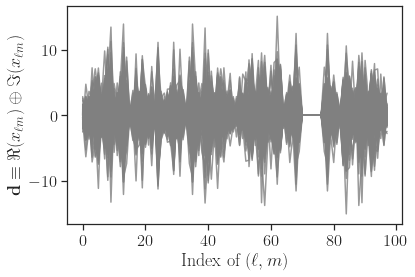

In [9]:
for i in range(200):
    plt.plot(samples['x'][i], color="gray", alpha=0.8)
plt.xlabel(r"Index of $(\ell,m)$")
plt.ylabel(r"$\mathbf{d}\equiv\Re(x_{\ell m})\oplus\Im(x_{\ell m})$")

In [10]:
dm = swyft.SwyftDataModule(samples[:], val_fraction = 0.2, batch_size = 2048)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='SBI_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min', every_n_epochs=1)
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='Dirty_map_logs', version=None)

# auto_lr_find=True, 
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 1000, devices=1,   auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=5e-6, weight_decay=1e-3, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
trainer.fit(network, dm)#ckpt_path="./logs/AE_logs/version_67/checkpoints/epoch=46-step=1504.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | logratios_1D | LogRatioEstimator_1dim | 23.6 K
--------------------------------------------------------
23.6 K    Trainable params
0         Non-trainable params
23.6 K    

Sanity Checking DataLoader 0:   0%|                     | 0/2 [00:00<?, ?it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|███████▏ | 40/50 [00:02<00:00, 16.95it/s, loss=0.00133, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████▊| 49/50 [00:02<00:00, 18.41it/s, loss=0.00133, v_num=9]
Epoch 0: 100%|█| 50/50 [00:02<00:00, 18.53it/s, loss=0.00133, v_num=9, val_los
Epoch 1:  80%|▊| 40/50 [00:01<00:00, 24.99it/s, loss=0.000549, v_num=9, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                         | 0/10 [00:00<?, ?it/s]
Epoch 1:  82%|▊| 41/50 [00:01<00:00, 25.07it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  84%|▊| 42/50 [00:01<00:00, 25.04it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  86%|▊| 43/50 [00:01<00:00, 25.15it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  88%|▉| 44/50 [00:01<00:00, 25.25it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  90%|▉| 45/50 [00:01<00:00, 25.36it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  92%|▉| 46/50 [00:01<00:00, 25.47it/s, loss=0.000549, v_num=9, val_lo
Epoch 1:  94%|▉| 47/50 [00:01<00:00, 25.56it/s, loss=0.000549, v_num=

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /scratch/haowen.zhong/SBI/logs/Dirty_map_logs/version_9/checkpoints/epoch=181-step=7280.ckpt


In [11]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/Dirty_map_logs/version_9/checkpoints/epoch=181-step=7280.ckpt",
    map_location=torch.device('cpu')
)

trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 1000, devices=1, auto_lr_find=True, precision=64)
network = AE(lr=5e-8, weight_decay=1e-6, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
network.load_state_dict(ckpt['state_dict'])

/local/haowen.zhong/ipykernel_3922171/2274334621.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: True
TPU available:

<All keys matched successfully>

/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Text(0, 0.5, '$x_{\\ell m}$')

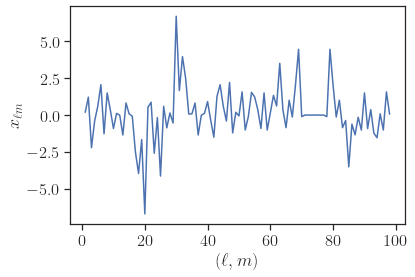

In [12]:
test_data = sim.sample(conditions={'z':-98.6})
test_data['x'] = preprocessing(test_data['x'])

l = np.arange(1,99,1)
plt.plot(l, test_data['x'])
plt.xlabel(r"$(\ell, m)$")
plt.ylabel(r"$x_{\ell m}$")

In [13]:
# Define priors
log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)
# Sample 1000 points from the priors
z_log_d = log_d_prior.rvs(100000).reshape([100000, 1])

# Create prior samples
prior_samples = swyft.Samples(z = z_log_d)
predictions = trainer.infer(network, test_data, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0:   9%|█▌               | 9/98 [00:00<00:01, 55.05it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 52.92it/s]


Text(0.5, 0, '$\\log_{10}d$')

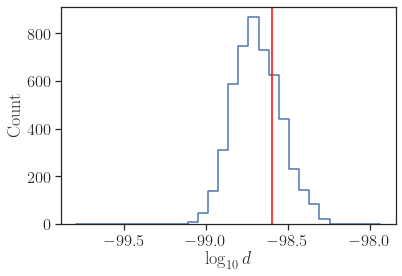

In [14]:
ln_r = np.asarray(predictions.logratios)
r_1 = np.exp(ln_r.reshape(-1))
post_log_d = np.random.choice(z_log_d.reshape(-1), size=5000, p = r_1/np.sum(r_1))

sns.histplot(post_log_d, bins=30, element="step", fill=False)
#plt.xscale("log")
plt.axvline(test_data['z'], color="red")
plt.xlabel(r"$\log_{10}d$")

/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 52.87it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 53.25it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 62.79it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|███████████████| 98/98 [00:00<00:00, 116.73it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 65.21it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|███████████████| 98/98 [00:00<00:00, 122.13it/s]


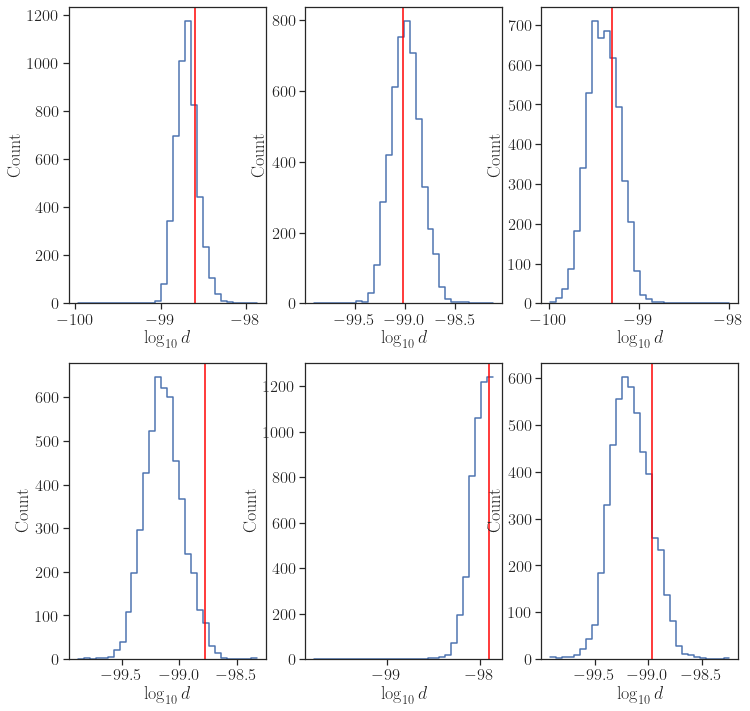

In [15]:
fix, axes = plt.subplots(2, 3, figsize = (12, 12))
for i in range(2):
    for j in range(3):
        ax = axes[i][j]
        test_data = sim.sample(conditions={'z':np.random.uniform(-100, -97.85387196432177)})
        test_data['x'] = preprocessing(test_data['x'])

        # Define priors
        log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)
        # Sample 1000 points from the priors
        z_log_d = log_d_prior.rvs(100000).reshape([100000, 1])
        
        # Create prior samples
        prior_samples = swyft.Samples(z = z_log_d)
        predictions = trainer.infer(network, test_data, prior_samples)

        ln_r = np.asarray(predictions.logratios)
        r_1 = np.exp(ln_r.reshape(-1))
        post_log_d = np.random.choice(z_log_d.reshape(-1), size=5000, p = r_1/np.sum(r_1))
        
        sns.histplot(post_log_d, bins=30, element="step", fill=False, ax=ax)
        #plt.xscale("log")
        ax.axvline(test_data['z'], color="red")
        ax.set_xlabel(r"$\log_{10}d$")

  0%|                                                | 0/1000 [00:00<?, ?it/s]/local/haowen.zhong/ipykernel_3922171/2218830510.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cl_mc[l] = d*(l**c)
/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

Predicting DataLoader 0: 100%|████████████████| 32/32 [00:00<00:00, 53.68it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████| 1000/1000 [00:15<00:00, 63.60it/s]


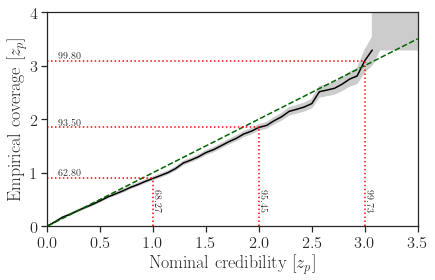

In [16]:
log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)     

# Sample 1000 points from the priors
z_log_d = log_d_prior.rvs(1000).reshape([1000, 1])
prior_samples = swyft.Samples(z = z_log_d)

sims = sim.sample(N = 1000)
sims['x'] = preprocessing(sims['x'])
coverage_samples = trainer.test_coverage(network, sims[-1000:], prior_samples)


fix, axes = plt.subplots(1, 1, figsize = (6, 4))
swyft.plot_zz(coverage_samples, "z[0]", ax=axes)
plt.tight_layout()

# Define a summarizer

In [19]:
class AE(swyft.SwyftModule,swyft.AdamW):
    def __init__(self, lr = 1e-5, gamma=0.98, weight_decay=0.01, lr_scheduler_factor=0.1):
        super().__init__()
        
        marginals = ((0,1), )
        self.learning_rate = lr
        self.lr_scheduler_factor = lr_scheduler_factor
        self.weight_decay = weight_decay
        self.gamma = gamma
#       AE-Summarizer
        self.summarizer =  nn.Sequential(
            nn.Linear(98, 49),
            nn.GELU(),
            nn.Linear(49, 32),
            nn.GELU(),
            nn.Linear(32, 16),
            nn.GELU(),
            nn.Linear(16, 4),
        )

        
        self.logratios_1D = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Number of features in compressed x (simulated observation)
            num_params=1,    # Two parameters to infer: alpha and omega
            varnames='z', 
            dropout = 0# Names of the parameters
            # Number of neural network blocks
        )
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        return self.logratios_1D(s, B['z']), s

In [20]:
# Define Simulator
#initialize L_max
Lmax = 6
# Fisher matrix scaling factor
ff = 1.0
# Model parameter values
# cval is just a power-law index, but why do we choose dval to be such a weird number? what's the good prior range of it?
# Is this file only for alpha=2/3 case?
o3_file = "./all_pproc_sph_a2over3_lmax30_rerun20210424.mat" #O3 HL fisher matrix
o3_data = loadmat(o3_file)
fisher = o3_data['Fisher']
subfisher = subFisher(fisher, Lmax)
subfisher = subfisher / ff
sim = Simulator(Lmax, subfisher, bounds=None)

In [21]:
samples = sim.sample(1)
saved_samples = np.load("./simulated_x_lm_withNoise.npz")
samples['x'] = preprocessing(saved_samples['x'])
samples['z'] = saved_samples['z']

  0%|                                                   | 0/1 [00:00<?, ?it/s]/local/haowen.zhong/ipykernel_3922171/2218830510.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cl_mc[l] = d*(l**c)
/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

Text(0, 0.5, '$x_{\\ell m}$')

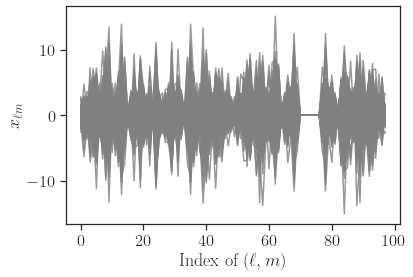

In [23]:
for i in range(200):
    plt.plot(samples['x'][i], color="gray", alpha=0.8)
plt.xlabel(r"Index of $(\ell,m)$")
plt.ylabel(r"$x_{\ell m}$")

In [24]:
dm = swyft.SwyftDataModule(samples[:], val_fraction = 0.2, batch_size = 2048)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='SBI_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min', every_n_epochs=1)
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='Dirty_map_logs', version=None)

# auto_lr_find=True, 
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 1000, devices=1,   auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=8e-6, weight_decay=1e-3, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
trainer.fit(network, dm)#ckpt_path="./logs/AE_logs/version_67/checkpoints/epoch=46-step=1504.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | summarizer   | Sequential             | 7.0 K 
1 | logratios_1D | LogRatioEstimator_1dim | 17.6 K
--------------------------------------------------------
24.6 K    Trainab

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (

Epoch 0:  80%|█████▌ | 40/50 [00:01<00:00, 24.37it/s, loss=0.000378, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████▊| 49/50 [00:01<00:00, 25.71it/s, loss=0.000378, v_num=10]
Epoch 0: 100%|█| 50/50 [00:01<00:00, 25.98it/s, loss=0.000378, v_num=10, val_l
Epoch 1:  80%|▊| 40/50 [00:00<00:00, 41.67it/s, loss=-0.00163, v_num=10, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                         | 0/10 [00:00<?, ?it/s]
Epoch 1:  82%|▊| 41/50 [00:00<00:00, 41.60it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  84%|▊| 42/50 [00:01<00:00, 41.73it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  86%|▊| 43/50 [00:01<00:00, 41.87it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  88%|▉| 44/50 [00:01<00:00, 42.00it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  90%|▉| 45/50 [00:01<00:00, 42.13it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  92%|▉| 46/50 [00:01<00:00, 42.25it/s, loss=-0.00163, v_num=10, val_l
Epoch 1:  94%|▉| 47/50 [00:01<00:00, 42.37it/s, loss=-0.00163, v_num=

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/Dirty_map_logs/version_10/checkpoints/epoch=862-step=34520.ckpt",
    map_location=torch.device('cpu')
)

trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 1000, devices=1, auto_lr_find=True, precision=64)
network = AE(lr=5e-8, weight_decay=1e-6, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
network.load_state_dict(ckpt['state_dict'])

/local/haowen.zhong/ipykernel_3922171/1503652213.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: True
TPU available:

<All keys matched successfully>

/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Text(0, 0.5, '$x_{\\ell m}$')

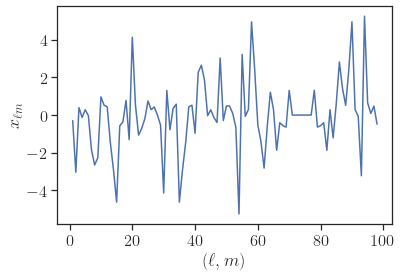

In [26]:
test_data = sim.sample(conditions={'z':-98.6})
test_data['x'] = preprocessing(test_data['x'])

l = np.arange(1,99,1)
plt.plot(l, test_data['x'])
plt.xlabel(r"$(\ell, m)$")
plt.ylabel(r"$x_{\ell m}$")

In [27]:
# Define priors
log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)
# Sample 1000 points from the priors
z_log_d = log_d_prior.rvs(100000).reshape([100000, 1])

# Create prior samples
prior_samples = swyft.Samples(z = z_log_d)
predictions = trainer.infer(network, test_data, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 59.51it/s]


Text(0.5, 0, '$\\log_{10}d$')

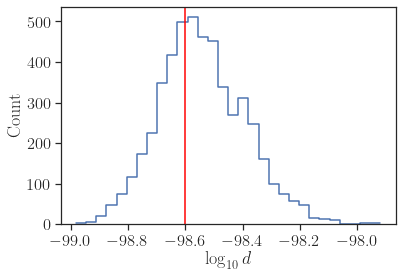

In [28]:
ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r.reshape(-1))
post_log_d = np.random.choice(z_log_d.reshape(-1), size=5000, p = r_1/np.sum(r_1))

sns.histplot(post_log_d, bins=30, element="step", fill=False)
#plt.xscale("log")
plt.axvline(test_data['z'], color="red")
plt.xlabel(r"$\log_{10}d$")

/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 65.47it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 56.64it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 62.40it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:00<00:00, 98.59it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|███████████████| 98/98 [00:00<00:00, 146.08it/s]


/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx2] = complex(sign*a,sign*(-b))
/local/haowen.zhong/ipykernel_3922171/2218830510.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[iip][jj] + ((-1)**abs(m))*covmat[ii][jjp] + ((-1)**abs(q+m))*covmat[iip][jjp])
/local/h

Predicting DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 85.45it/s]


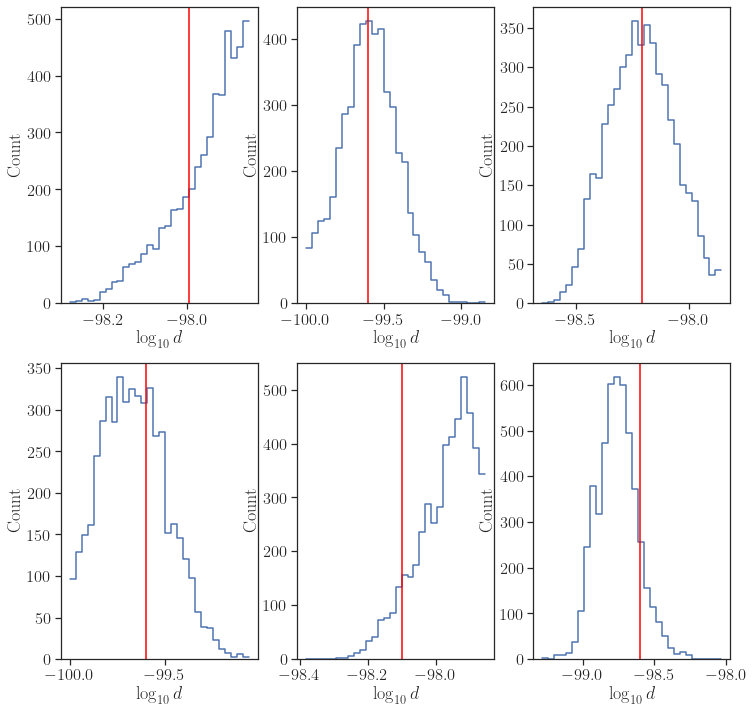

In [29]:
fix, axes = plt.subplots(2, 3, figsize = (12, 12))
for i in range(2):
    for j in range(3):
        ax = axes[i][j]
        test_data = sim.sample(conditions={'z':np.random.uniform(-100, -97.85387196432177)})
        test_data['x'] = preprocessing(test_data['x'])

        # Define priors
        log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)
        # Sample 1000 points from the priors
        z_log_d = log_d_prior.rvs(100000).reshape([100000, 1])
        
        # Create prior samples
        prior_samples = swyft.Samples(z = z_log_d)
        predictions = trainer.infer(network, test_data, prior_samples)

        ln_r = np.asarray(predictions[0].logratios)
        r_1 = np.exp(ln_r.reshape(-1))
        post_log_d = np.random.choice(z_log_d.reshape(-1), size=5000, p = r_1/np.sum(r_1))
        
        sns.histplot(post_log_d, bins=30, element="step", fill=False, ax=ax)
        #plt.xscale("log")
        ax.axvline(test_data['z'], color="red")
        ax.set_xlabel(r"$\log_{10}d$")

  0%|                                                | 0/1000 [00:00<?, ?it/s]/local/haowen.zhong/ipykernel_3922171/2218830510.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cl_mc[l] = d*(l**c)
/local/haowen.zhong/ipykernel_3922171/2218830510.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plm_model[idx] = complex(a,b)                            # assign complex value to appropriate index of plm array
/local/haowen.zhong/ipykernel_3922171/2218830510.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

Predicting DataLoader 0: 100%|████████████████| 32/32 [00:00<00:00, 68.22it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████| 1000/1000 [00:12<00:00, 78.83it/s]


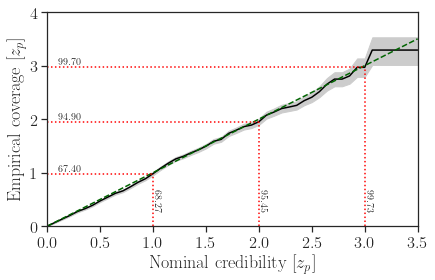

In [30]:
log_d_prior = stats.uniform(-100, np.log10(140*1e-100)+100)     

# Sample 1000 points from the priors
z_log_d = log_d_prior.rvs(1000).reshape([1000, 1])
prior_samples = swyft.Samples(z = z_log_d)

sims = sim.sample(N = 1000)
sims['x'] = preprocessing(sims['x'])
coverage_samples = trainer.test_coverage(network, sims[-1000:], prior_samples)


fix, axes = plt.subplots(1, 1, figsize = (6, 4))
swyft.plot_zz(coverage_samples, "z[0]", ax=axes)
plt.tight_layout()